## Importing modules

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from boundary import *
from tools import *
from oper import *

rtype = np.float32

## input parameters

In [35]:
## Setting parameter

nx = 201 
nz = 201
nt = 1001
npml = 0

dx = 10.
dz = 10.
dt = 1e-3

order = 2

## set model

In [36]:
vp=np.ones((nx,nz),rtype)*3000
rho=np.ones((nx,nz),rtype)*1.

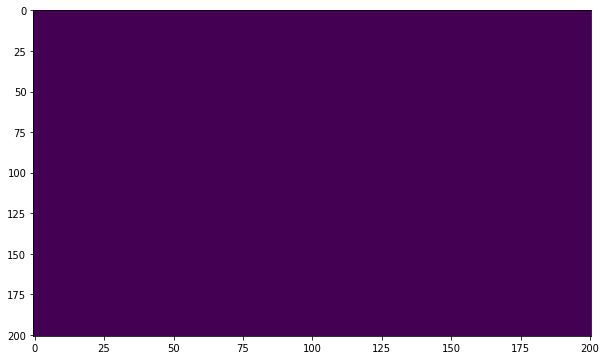

In [37]:
fig = plt.figure(figsize=(10,6))

plt.imshow(vp,aspect='auto')
# plt.savefig('True_velocity.jpg')
#     

## set source & receiver

In [38]:
nshot = 1
# sx = 100 + order + npml
# sz = 100 + order + npml

# rx = 2 + order
# rz = 2 + order


## shot
nshot = 1
fshot_x = 100
dshot_x = 0
fshot_z = 100
dshot_z = 0

## receiver
nrcv = nx
frcv_x = 2
drcv_x = 1
frcv_z = 2
drcv_z = 0


sx,sz = ass_shot(nshot,fshot_x,dshot_x,fshot_z,dshot_z,npml,order)
ishot = 0;
geom_ID = 1;

rx,rz = ass_rcv(ishot,nrcv,frcv_x,drcv_x,frcv_z,drcv_z,npml,order,geom_ID)


In [39]:
## Source

f0 = 5
fmax = f0*3

factor=1; t0=1.2/f0  
a=(np.pi*f0)**2
ricker=np.zeros((nt),rtype)
for it in np.arange(nt):
    dm = a*((it*dt-t0)**2)
    ricker[it] = factor*(1-(2*dm))*np.exp(-dm)
source=ricker


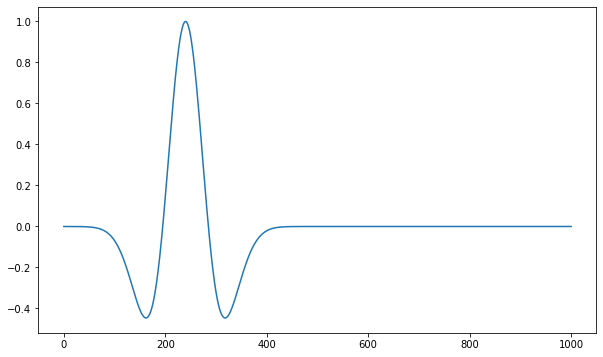

<Figure size 432x288 with 0 Axes>

In [40]:
fig = plt.figure(figsize=(10,6))

plt.plot(source)
plt.show()
plt.savefig('Source.jpg')

## 2D forward modeling

In [41]:
mnx = nx + order
mnz = nz + order

rho = np.ones((mnx, mnz), rtype)
u1 = np.zeros((mnx, mnz), rtype)
u2 = np.zeros_like(u1)
u3 = np.zeros_like(u1)
shot = np.zeros_like(u1)
shot[sz, sx] = 1
mvp = np.ones((mnx, mnz), rtype) * 3000
wavefield = np.zeros((mnx, mnz, nt), rtype)

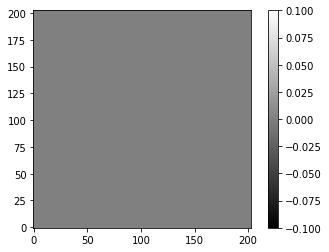

In [42]:
c= 3000;

# Time loop
for t in range(nt):
    for i in range(1, mnx - 1):
        for j in range(1, mnz - 1):
            u3[i, j] = 2 * u2[i, j] - u1[i, j] + ((mvp[i, j] * dt) ** 2) * (
                (u2[i, j + 1] - 2 * u2[i, j] + u2[i, j - 1]) / dx ** 2 +
                (u2[i + 1, j] - 2 * u2[i, j] + u2[i - 1, j]) / dz ** 2)
            u3[i, j] = u3[i, j] + (dt ** 2) * (shot[i, j] * source[t])

    # Store wavefield
    wavefield[:, :, t] = u3

    # Clayton-Engquist absorbing boundary condition
    u3[0, :] = u1[1, :] + (c*dt-dx)/(c*dt+dx) * (u3[1, :] - u1[0, :])
    u3[-1, :] = u1[-2, :] + (c*dt-dx)/(c*dt+dx) * (u3[-2, :] - u1[-1, :])
    u3[:, 0] = u1[:, 1] + (c*dt-dz)/(c*dt+dz) * (u3[:, 1] - u1[:, 0])
    u3[:, -1] = u1[:, -2] + (c*dt-dz)/(c*dt+dz) * (u3[:, -2] - u1[:, -1])
 

    wavefield[:,:,t] = u3
    # Update time steps
    u1 = u2.copy()
    u2 = u3.copy()
    u3 = np.zeros((mnx, mnz), rtype)

# Plot the final solution
plt.imshow(u3, cmap='gray', origin='lower')
plt.colorbar()
plt.show()

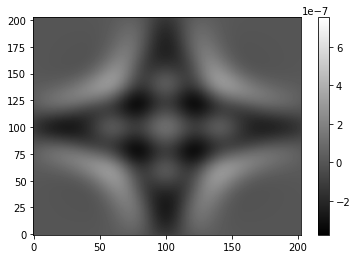

In [53]:
# plt.imshow(wave[100,:,:],aspect='auto')
wmin=np.min(wavefield); wmax=np.max(wavefield)
plt.imshow(wavefield[:,:,1000],aspect='auto', cmap='gray', origin='lower',vmin=wmin*0.1,vmax=wmax*0.1)
plt.colorbar()
plt.savefig('Clayton_Engquist_wave_1sec.jpg')